## Imported Modules

In [1]:
import tensorflow as tf
from keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

import pandas as pd
import numpy as np
import os
import shutil
import pathlib
from glob import glob

import requests 
from bs4 import BeautifulSoup
import urllib.request

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Global Variables

In [2]:
NUM_CLASSES = 2
NUM_EPOCHS = 15
BATCH_SIZE = 32
IMG_SIZE = (224,224) # Expected size for ResNet50
LR = 0.1

## Load Lucy Images

In [122]:
# Load and convert images to .jpeg

img_dir = "/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/images/lucy/"

for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        img = Image.open(img_dir + file)
        file_name, file_ext = os.path.splitext(file)
        new_name = file_name + ".jpeg"
        img.save(img_dir + new_name)

In [123]:
# Delete the .JPG and.jpg files

for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        path_to_file = os.path.join("/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/images/lucy/", file)
        os.remove(path_to_file)

## Download Other Images (Not Lucy)

In [124]:
# # Function to grab image urls from a url

# def getdata(url): 
#     r = requests.get(url) 
#     return r.text 
    
# htmldata = getdata("https://unsplash.com/s/photos/french-bulldog") 
# soup = BeautifulSoup(htmldata, 'html.parser')
# img_list = [item['src'] for item in soup.find_all("img")]

In [125]:
# # Save the image files

# i = 0
# while i < len(img_list):
#     f_name = "/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/images/other/" + str(i) + ".jpeg"
#     urllib.request.urlretrieve(img_list[i], f_name)
#     i+=1

## Train / Test Split

### Lucy Images

In [136]:
# Generate a list of the image files
lucy_image_files = glob("../images/lucy/*.jpeg")

# Strip the extensions
lucy_image_names = [name.replace(".jpeg","") for name in lucy_image_files]

# Split into train and test
lucy_train_names, lucy_test_names = train_test_split(lucy_image_names, test_size=0.2)

def batch_move_files(file_list, source_path, destination_path):
    """Moves jpeg files to destination path from source path"""
    
    for file in file_list:
        image = file + ".jpeg"
        shutil.move(image, destination_path)
    
    return

# Move the files - assumes empty train and test directories at the images directory level

source_dir = "../images/lucy/"
val_dir = "../images/val/lucy/"
train_dir = "../images/train/lucy/"
batch_move_files(lucy_test_names, source_dir, val_dir)
batch_move_files(lucy_train_names, source_dir, train_dir)

### Other Images

In [137]:
# Generate a list of the image files
other_image_files = glob("../images/other/*.jpeg")

# Strip the extensions
other_image_names = [name.replace(".jpeg","") for name in other_image_files]

# Split into train and test
other_train_names, other_test_names = train_test_split(other_image_names, test_size=0.2)

# Move the files - assumes empty train and test directories at the images directory level

source_dir = "../images/other/"
val_dir = "../images/val/other/"
train_dir = "../images/train/other/"
batch_move_files(other_test_names, source_dir, val_dir)
batch_move_files(other_train_names, source_dir, train_dir)

## Image Augmentation

In [3]:
# Create generators and preprocess input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
# Use the generators

train_generator = train_datagen.flow_from_directory("../images/train/",
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=42,
                                                    class_mode="categorical")

val_generator = val_datagen.flow_from_directory("../images/val/",
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode="categorical")

Found 273 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


## Define and Train Model

In [15]:
# Instantiate base model from ResNet50 and exclude head

tf.keras.backend.clear_session()

base_model = ResNet50(include_top=False,
                      input_shape=IMG_SIZE + (3,),
                      weights="imagenet")

# Freeze all layers

for layer in base_model.layers[:]:
    layer.trainable = False
    
# Customize the model by adding Dense layers
# Include Dropout and Normalization to combat overfitting

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Resizing(224,224))
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"))

# Compile model

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=["acc"])

In [16]:
# Fit the model

history = model.fit(train_generator,
                    epochs=NUM_EPOCHS,
                    validation_data=val_generator)

Epoch 1/15


2022-06-15 16:01:12.237655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 1.2608 - acc: 0.5311

2022-06-15 16:01:28.739336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 21s 2s/step - loss: 1.2608 - acc: 0.5311 - val_loss: 732.3392 - val_acc: 0.5574
Epoch 2/15
9/9 [==============================] - 17s 2s/step - loss: 0.7677 - acc: 0.6154 - val_loss: 117.2024 - val_acc: 0.5082
Epoch 3/15
9/9 [==============================] - 17s 2s/step - loss: 0.6928 - acc: 0.6410 - val_loss: 64.6458 - val_acc: 0.5082
Epoch 4/15
9/9 [==============================] - 17s 2s/step - loss: 0.6097 - acc: 0.6923 - val_loss: 17.4339 - val_acc: 0.5738
Epoch 5/15
9/9 [==============================] - 17s 2s/step - loss: 0.4518 - acc: 0.8095 - val_loss: 11.5462 - val_acc: 0.6557
Epoch 6/15
9/9 [==============================] - 17s 2s/step - loss: 0.4371 - acc: 0.8022 - val_loss: 4.9653 - val_acc: 0.6557
Epoch 7/15
9/9 [==============================] - 16s 2s/step - loss: 0.3635 - acc: 0.8388 - val_loss: 3.2380 - val_acc: 0.6885
Epoch 8/15
9/9 [==============================] - 16s 2s/step - loss: 0.3274 - acc: 0.8718 - val_loss: 1.340

## Evaluate Model

### Architecture

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, None)    0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

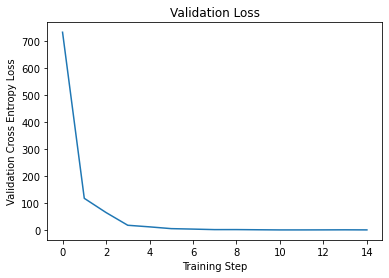

In [18]:
# Visualize loss curve

losses = history.history['val_loss']
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Validation Cross Entropy Loss')
plt.title('Validation Loss')
plt.show()

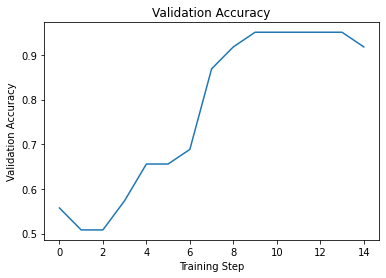

In [19]:
# Visualize accuracy

losses = history.history['val_acc']
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [20]:
# Table of history

hist_df = pd.DataFrame(history.history)
hist_df

,loss,acc,val_loss,val_acc
0,1.260844,0.531136,732.339172,0.557377
1,0.767656,0.615385,117.202438,0.508197
2,0.692809,0.641026,64.645821,0.508197
3,0.609692,0.692308,17.433874,0.573771
4,0.451766,0.809524,11.546233,0.655738
5,0.437102,0.802198,4.965349,0.655738
6,0.363469,0.838828,3.238041,0.688525
7,0.327429,0.871795,1.340139,0.868852
8,0.223773,0.919414,1.437438,0.918033
9,0.164384,0.930403,0.786063,0.950820


In [21]:
model.save("/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/models/model.h5")

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Prepare Test Set

In [22]:
# Preprocess the test images to expected shape

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory("../images/test/",
                                                    target_size=IMG_SIZE,
                                                    batch_size=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

Found 24 images belonging to 2 classes.


### Test the Model

In [23]:
# Generate predictions

tf.keras.backend.clear_session()
model = load_model("/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/models/model.h5")
predictions = model.predict(test_generator)

2022-06-15 16:05:59.358601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [24]:
# Evaluate model

model.evaluate(test_generator)

2022-06-15 16:06:03.120948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 2s 51ms/step - loss: 0.1695 - acc: 0.9583


[0.16945992410182953, 0.9583333730697632]